In [8]:
from save_activations import load_activation_probing_dataset, load_activation_probing_dataset_args
from feature_datasets import common
from probes.evaluation import *

In [9]:
def get_target_values(entity_df, feature_name):
    if feature_name == 'coords':
        target = entity_df[['longitude', 'latitude']].values

    elif feature_name.endswith('date') or feature_name.endswith('year'):
        if feature_name == 'death_year':
            target = entity_df[feature_name].values
        else:
            NS_PER_YEAR = 1e9 * 60 * 60 * 24 * 365.25
            target = pd.to_datetime(entity_df[feature_name]).values
            target = target.astype(np.int64) / NS_PER_YEAR
    else:
        raise ValueError(f'Unrecognized feature name: {feature_name}')
    return target

In [10]:
import torch
import pandas as pd
from sklearn.linear_model import Ridge, RidgeCV
import matplotlib.pyplot as plt
import tqdm
from typing import Any

In [11]:
LLAMA = "Llama-2-13b-hf"
NUM_LAYERS = 40

In [12]:
def run_probe(layer_ix: int, entity_type: str, feature_name: str,
              prompt_name: str = "empty", model: str = LLAMA, alpha: float = None) -> dict:
    activations = load_activation_probing_dataset(model=model, entity_type=entity_type,
                                                  prompt_name=prompt_name, layer_ix=layer_ix)
    activations = activations.dequantize()
    
    entity_df = common.load_entity_data(entity_type)
    is_test = entity_df.is_test
    
    target = get_target_values(entity_df, feature_name)
    
    train_activations = activations[~is_test]
    train_target = target[~is_test]
    
    test_activations = activations[is_test]
    test_target = target[is_test]
    
    if alpha is None:
        alpha = activations.shape[1]
    probe = Ridge(alpha=alpha)

    norm_train_target = (train_target - train_target.mean(0)
                         ) / train_target.std(0)
    
    probe.fit(train_activations, norm_train_target)
    
    train_pred = probe.predict(train_activations)
    test_pred = probe.predict(test_activations)
    
    train_pred_unnorm = train_pred * train_target.std(0) + train_target.mean(0)
    test_pred_unnorm = test_pred * train_target.std(0) + train_target.mean(0)
    
    is_place = entity_type.endswith("place")
    if is_place:
        train_scores = score_place_probe(train_target, train_pred_unnorm, use_haversine=True)
        test_scores = score_place_probe(test_target, test_pred_unnorm, use_haversine=True)
    else:
        train_scores = score_time_probe(train_target, train_pred_unnorm)
        test_scores = score_time_probe(test_target, test_pred_unnorm)
    
    scores = {
        **{('train', k): v for k, v in train_scores.items()},
        **{('test', k): v for k, v in test_scores.items()},
    }
    
    return scores

In [20]:
def train_on_all_layers(metric=None, **kwargs) -> Any:
    all_scores = []
    for layer_ix in tqdm.trange(NUM_LAYERS):
        scores = run_probe(layer_ix, **kwargs)
        all_scores.append(scores)

    if metric is not None:
        return [s[metric] for s in all_scores]
    return all_scores

def plot_scores(all_scores, title, metric=("test", "r2")):
    plt.plot([s[metric] for s in all_scores])
    plt.xlabel("layer_ix")
    plt.ylabel(metric)
    plt.title("probe results: " + title)
    plt.grid()

100%|██████████| 40/40 [07:43<00:00, 11.60s/it]


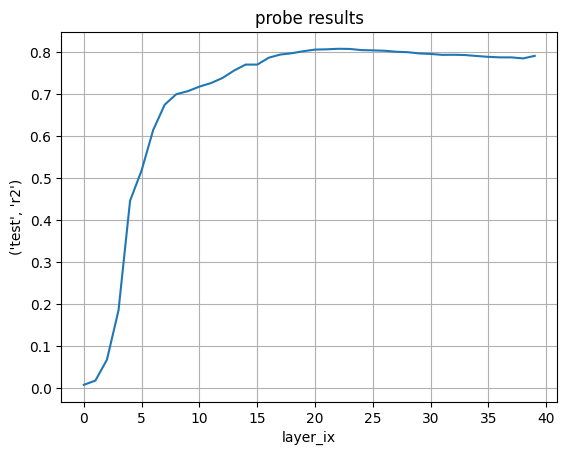

In [14]:
scores_us = train_on_all_layers(entity_type="us_place", feature_name="coords")

100%|██████████| 40/40 [07:31<00:00, 11.29s/it]


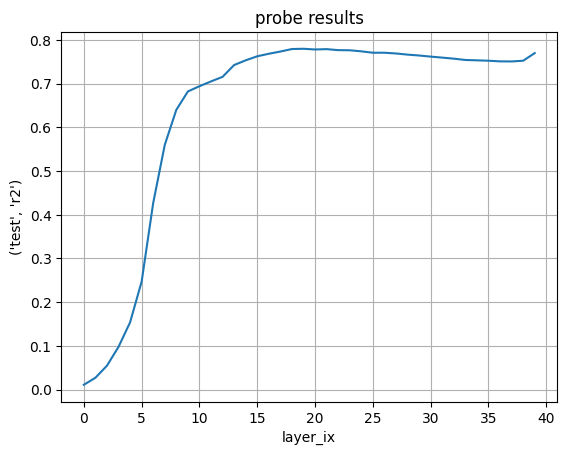

In [15]:
scores_art = train_on_all_layers(entity_type="art", feature_name="release_date")
plot_scores(scores_art, title="art")

100%|██████████| 40/40 [07:01<00:00, 10.53s/it]


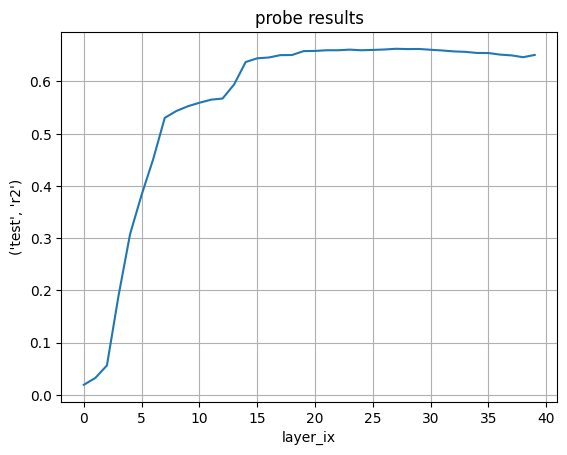

In [16]:
scores_headline = train_on_all_layers(entity_type="headline", feature_name="pub_date")
plot_scores(scores_headline, title="headline")

100%|██████████| 40/40 [09:22<00:00, 14.05s/it]


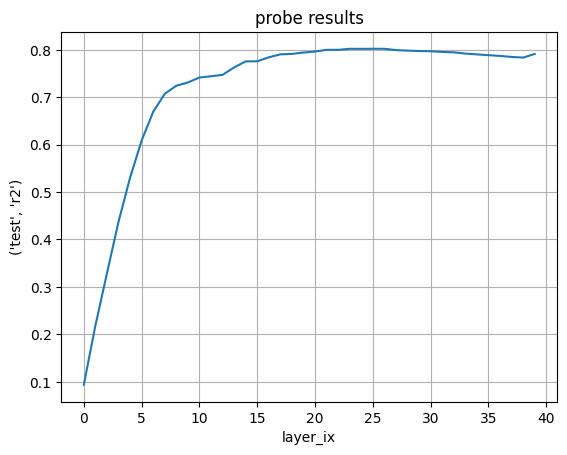

In [17]:
scores_histor = train_on_all_layers(entity_type="historical_figure", feature_name="death_year")
plot_scores(scores_histor, title="historical figure")

100%|██████████| 40/40 [05:16<00:00,  7.92s/it]


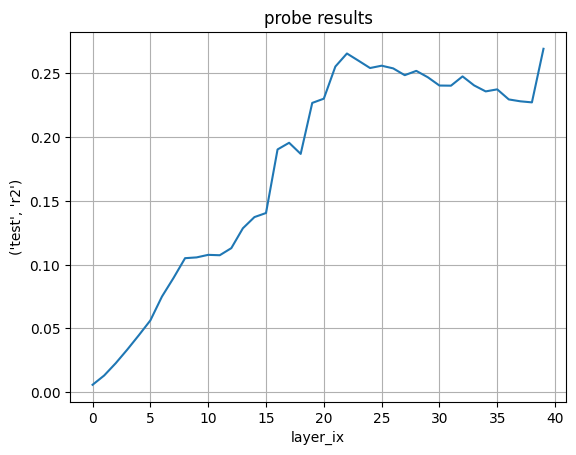

In [18]:
scores_nyc = train_on_all_layers(entity_type="nyc_place", feature_name="coords")
plot_scores(scores_nyc, title="NYC place")

100%|██████████| 40/40 [09:47<00:00, 14.68s/it]


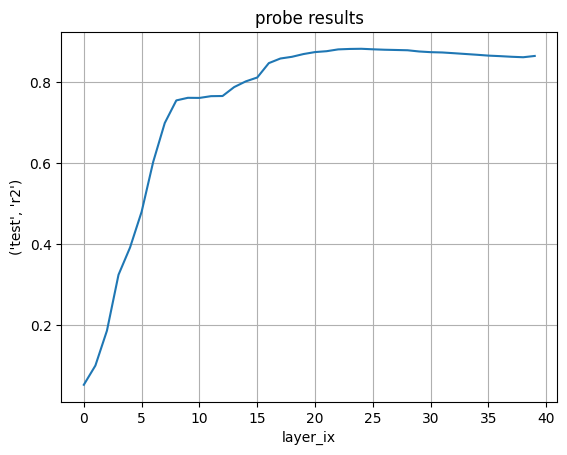

In [19]:
scores_world = train_on_all_layers(entity_type="world_place", feature_name="coords")
plot_scores(scores_world, title="world place")